In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## HyperLogLog

In this task we use the HLL data structure to produce an estimate of the number of distinct strings in the file `hash.txt`.

The command `cat hash.txt | uniq | wc -l` has been used to produce the exact count which is *139000000* distinct strings.

The underlying hash function used by HLL has been implemented according to the **multiply-shift** scheme defined on [Wikipedia](https://en.wikipedia.org/wiki/Universal_hashing). 

We use *32 bits* for the hash, i.e. $$h:\big\{U \rightarrow [m]\big\}$$ where $m=2048$.

We then use *6 bits* for the buckets, i.e. *64 buckets*, so according to [Flajolet et. al](http://algo.inria.fr/flajolet/Publications/FlFuGaMe07.pdf) we can expect $1.04/\sqrt(m)$ relative accuracy.

Recall the formula of relative accuracy is given by:

$$RE_{accuracy} = \frac{\mbox{absolute error}}{\mbox{"true" value}} \cdot 100\%$$

Which in this setting should expect a **2.30% relative accuracy**

In [40]:
from my_hyperloglog import *

estimate = estimate_distinct("full_hash.txt")
re_acc = relative_accuracy(estimate)

print("Distinct elements: ", estimate)
print("Relative accuracy: {:.2%}".format(re_acc))

Distinct elements:  141943507
Relative accuracy: 2.12%


## Cluster analysis of Amazon Reviews

We now focus on analyzing the reviews for [fine foods from Amazon](https://www.kaggle.com/snap/amazon-fine-food-reviews) using the **KMeans algorithm** implemented from scratch.

Here's the dataset we're working on:

In [3]:
from data_loader import load_data
from plots import *
from kmeans import *
from utils import *

reviews_df = load_data()
reviews_df.head()

,ProductId,UserId,Score,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,5,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,1,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,4,This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,2,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,5,Great taffy at a great price. There was a wid...


First we need to preprocess the Text column, we can do this by changing the call to `load_data()` and if the preprocessed `.csv` has not been generated before it will do it on the fly.

In [4]:
processed_reviews_df = load_data(processed=True)
reviews_list = processed_reviews_df['ProcessedText'].dropna()
processed_reviews_df.head()

,ProductId,UserId,Score,Text,ProcessedText
0,B001E4KFG0,A3SGXH7AUHU8GW,5,I have bought several of the Vitality canned d...,i have bought sever of the vital can dog food ...
1,B00813GRG4,A1D87F6ZCVE5NK,1,Product arrived labeled as Jumbo Salted Peanut...,product arriv label as jumbo salt peanut the p...
2,B000LQOCH0,ABXLMWJIXXAIN,4,This is a confection that has been around a fe...,thi is a confect that ha been around a few cen...
3,B000UA0QIQ,A395BORC6FGVXV,2,If you are looking for the secret ingredient i...,if you are look for the secret ingredi in robi...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,5,Great taffy at a great price. There was a wid...,great taffi at a great price there wa a wide a...


Now we need to transform the reviews into high dimensional vectors in order to run the kmeans algorithm, to do so we use the tfidf representation by retaining only a maximum of 100 features (the words with the higher tfidf score).

The `min_df` parameters has been used to drop words that appear in less than 20% of the documents, this allowed to retain a higher variance.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
        stop_words='english',
        min_df=0.15
    )

reviews_tfidf = tfidf.fit_transform(reviews_list)
reviews_tfidf.shape

(568453, 16)

We still have quite a few components that would make kmeans slower, we can further reduce them by using SVD, in the graph below we see how the number of components affects the retain variance. We will use a number that allows to retain at least 60% variance.

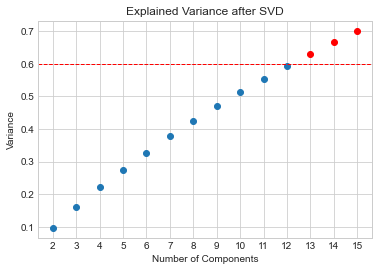

In [23]:
plot_variance(reviews_tfidf)

With 13 components we achieve the targeted variance.

In [11]:
svd = TruncatedSVD(n_components=13)
points = svd.fit_transform(reviews_tfidf)
svd.explained_variance_.sum()

0.6308490650424118

To run KMeans we need to decide the number of clusters, one way to do it is using the **elbow method**, we look for a clear bend in the graph of **sum of squares error** as the number of clusters increases.

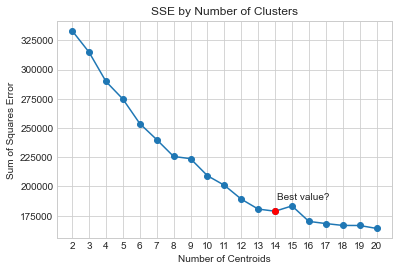

In [17]:
simulation_data = kmeans_simulation(points)
plot_sse(simulation_data)